# Задание 3. Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
D = np.loadtxt('../data/lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]


При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [2]:
def mean_squared_error(X, Y, w, lmbd = 0):
    n, m = X.shape
    X = np.hstack([np.ones((n, 1)), X])
    return (1/n) * np.sum( (X @ w - Y) ** 2 + 0.5 * lmbd * np.linalg.norm(w) )
def linear_regression(X, Y, lmbd = 0):
    n, m = X.shape
    X = np.hstack([np.ones((n, 1)), X])
    w = np.linalg.inv(X.T @ X + lmbd * np.eye(m+1)) @ X.T @ Y
    return w


In [3]:
lmbd_list = np.linspace(0, 1, 100)

best lmbd is 0.04040404040404041


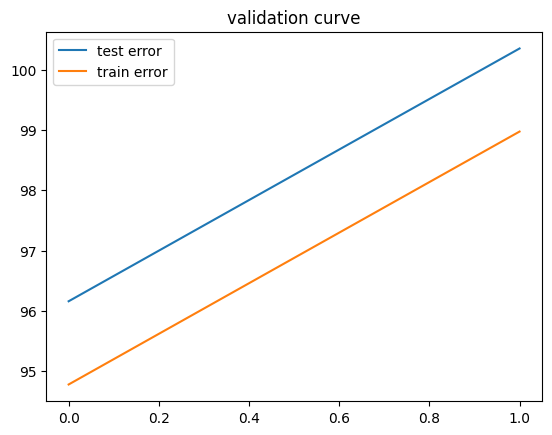

In [5]:
def chose_fold():
    i = 0
    while True:
        yield i
        i = (i + 1) % 5
def create_5_folds(length):
    np.random.seed(0)
    idx_seq = [i for i in range(length)]
    np.random.shuffle(idx_seq)
    folds = [[]for fold in range(5)]
    fold_idx = chose_fold()
    for idx in idx_seq:
        folds[next(fold_idx)].append(idx)
    return np.array(folds)

folds = create_5_folds(len(X))
train_errors = []
test_errors = []
for lmbd in lmbd_list:
    test_error = []
    train_error = []
    for fold_num in range(5):
        idxs = set(range(5))
        idxs.discard(fold_num)
        idxs = list(idxs)
        train, test = np.concatenate(folds[idxs]), folds[fold_num]
        w = linear_regression(X[train], Y[train], lmbd)
        train_error.append(mean_squared_error(X[train], Y[train], w, lmbd))
        test_error.append(mean_squared_error(X[test], Y[test], w, lmbd))
    test_errors.append(np.mean(test_error))
    train_errors.append(np.mean(train_error))
plt.plot(lmbd_list, test_errors, label = 'test error')
plt.plot(lmbd_list, train_errors, label = 'train error')
plt.title("validation curve")
print("best lmbd is {}".format(lmbd_list[np.argmin(test_error)]))
plt.legend()
lmbd = lmbd_list[np.argmin(test_error)] 


C:\Users\ber_v\AppData\Local\Temp\ipykernel_5456\800708222.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(folds)


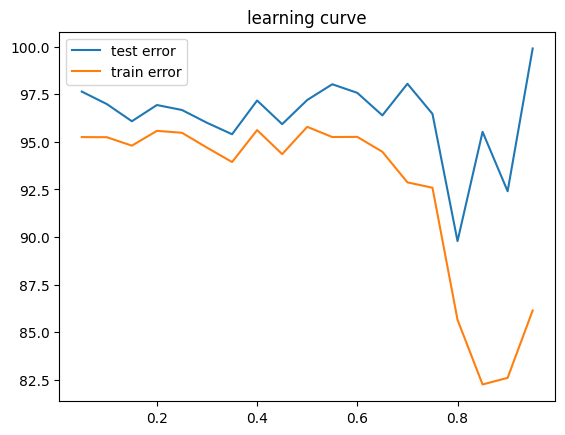

In [6]:
def take_less_rows(length, test_size):
    np.random.seed(0)
    idx_seq = [i for i in range(length)]
    np.random.shuffle(idx_seq)
    threshold = int(test_size * (length))
    return idx_seq[threshold+1:], idx_seq[:threshold+1]
train_errors = []
test_errors = []
for size in np.arange(0.05, 0.96, 0.05):
    tr, te = take_less_rows(len(X), size)
    X_less, Y_less = X[tr], Y[tr]
    folds = create_5_folds(len(X_less))

    test_error = []
    train_error = []
    for fold_num in range(5):
            idxs = set(range(5))
            idxs.discard(fold_num)
            idxs = list(idxs)
            train, test = np.concatenate(folds[idxs]), folds[fold_num]
            w = linear_regression(X_less[train], Y_less[train], lmbd)
            train_error.append(mean_squared_error(X_less[train], Y_less[train], w, lmbd))
            test_error.append(mean_squared_error(X_less[test], Y_less[test], w, lmbd))
    test_errors.append(np.mean(test_error))
    train_errors.append(np.mean(train_error))
plt.plot(np.arange(0.05, 0.96, 0.05), test_errors, label = 'test error')
plt.plot(np.arange(0.05, 0.96, 0.05), train_errors, label = 'train error')
plt.title('learning curve')
plt.legend()